In [2]:
import pandas as pd
import spacy
from collections import Counter
import re 
import pandas as pd 
import os
import numpy as np
import sys
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.feature_extraction.text import TfidfVectorizer
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [1]:
data = pd.read_csv("20newsgroups_processed.csv")
data.describe()

NameError: name 'pd' is not defined

In [3]:
data = pd.read_csv("20 newsgroups/20newsgroups.csv", on_bad_lines='skip', sep=';')
data = data.dropna()
data = data.drop_duplicates()
data = data.iloc[:,1:3]


dataSplit = data.drop(data[data["group"] == 1 ].index)
dataSplit = dataSplit.drop(data[data["group"] == 2 ].index) #Enthält Atheismus und Religion
dataAth = data.drop(data[data["group"] != 0 ].index)
dataReli = data.drop(data[data["group"] != 3 ].index)

nlp = spacy.load("en_core_web_sm")

dataSplit.head()

,text,group
1,"' Seems to be, barring evidence to the contra...",3
3,'I have a request for those who would like to ...,0
5,' There are definitely quite a few horrible de...,0
16,"' Size of armies, duration, numbers of casualt...",0
19,'DM> Fact or rumor....? Madalyn Murray O\'Har...,3


In [4]:
class trainMan:
    def __init__(self, path, 
                 max_depthVal=None, max_depthMax=200, max_depthMin=0, 
                 min_sample_splitVal = 2, min_sample_splitMax=10, min_sample_splitMin=2, 
                 clf=None, criterionVal="entropy"):
        self.path = path
        self.trainList = self.__data()
        self.max_depthVal = max_depthVal
        self.max_depthMax = max_depthMax
        self.max_depthMin=max_depthMin
        self.min_sample_splitMax = min_sample_splitMax
        self.min_sample_splitMin = min_sample_splitMin
        self.min_sample_splitVal = min_sample_splitVal
        self.clf = clf
        self.criterionVal = criterionVal
        self.results = np.empty((3, max_depthMax-max_depthMin, min_sample_splitMax-min_sample_splitMin, 3))
    def __data(self):
        self.data = pd.read_csv(self.path)
        columnsLength = self.data.shape[1]-1
        X = self.data.iloc[:,0:columnsLength]
        y = self.data[["groupID"]].values.ravel()
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        return [self.X_train, self.X_test, self.y_train, self.y_test]
    def get_X_train(self):
        """Gibt X_train zurück."""
        return self.X_train
    def out(self):
        if(self.clf == None):
            print("Modell ohne Parameter wird angelegt, da keines vorhanden:")
            self.clf = DecisionTreeClassifier(random_state=42)
            self.clf = self.clf.fit(self.trainList[0], self.trainList[2])
        predict = self.clf.predict(self.trainList[1])
        report = classification_report(self.trainList[3], predict, target_names=["Atheism", "Religion"])
        print(report)
        print("F-Score: ",f1_score(predict, self.trainList[3], average='macro'))
        print("Precision: ",precision_score(predict, self.trainList[3], average='macro'))
        print("Recall: ",recall_score(predict, self.trainList[3], average='macro'))
    def max_depth(self, min, max):
        self.max_depthMax = max
        self.max_depthMin = min
        f = 0
        for i in range(self.max_depthMax):
            if(i<self.max_depthMin):
                continue
            clf = DecisionTreeClassifier(random_state=42, criterion=self.criterionVal, max_depth=i, min_samples_split=self.min_sample_splitVal)
            clf = clf.fit(self.trainList[0], self.trainList[2])
            predict = clf.predict(self.trainList[1])
            if f1_score(predict, self.trainList[3], average='macro')>f:
                f = f1_score(predict, self.trainList[3], average='macro')
                self.max_depthVal = i
                self.clf =  DecisionTreeClassifier(random_state=42, criterion=self.criterionVal, max_depth=i, min_samples_split=self.min_sample_splitVal)
                self.clf = self.clf.fit(self.trainList[0], self.trainList[2])      
        return self.max_depthVal

Erster TFIDF Ansatz: 
- threshold gibt an ab welcher Relevanz ein Wort ein Feature wird
- Anschließend wird in jedem Text die Häufigkeit erfasst mit der diese relevanten Wörter vorkommen
- Erste Tests deuten auf eine stark verbesserte Performance von fast 0.7 bei einem Treshold von 0.4 hin (-> fast 0.05 besser als andere Ansätze)
Idee:
- Bei Anwendung auf 4 Kategorien könnte der Threshold der unterrepräsentierten Kategorien geringer sein um mehr mögliche    relevante Worte zu bekommen

In [23]:
threshold = 0.4  # Beispielwert, passe ihn nach Bedarf an

# Initialisiere den TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')  # Stopwords entfernen

# Berechne die TF-IDF-Werte für die Atheismus und Religion-Daten
tfidf_matrix = vectorizer.fit_transform(dataSplit["text"])

# Hole die Wortliste (Feature-Namen)
words = vectorizer.get_feature_names_out()

# Extrahiere die maximalen TF-IDF-Werte für jedes Wort in beiden Kategorien
tfidf_scores = tfidf_matrix.max(axis=0).toarray().flatten()

# Filtere Wörter, deren TF-IDF-Wert den Schwellenwert überschreiten
relevant_words = [words[i] for i in range(len(words)) if tfidf_scores[i] > threshold]

# Kombiniere beide Listen (optional) und gib sie aus
relevant_words = list(set(relevant_words))
print("Relevante Wörter:", relevant_words)
print(len(relevant_words))

Relevante Wörter: ['war', 'enviroleague', 'acceptable', 'mat26', 'quran', 'sign', 'observed', 'likes', 'rosicrucians', 'gun', 'heliocentric', 'objectivity', 'text', 'teven', 'cruel', 'questions', 'tandreas', 'base', 'whirr', 'tthere', 'sun', 'okay', 'aliens', 'defects', 'siding', 'coincidence', 'connotations', 'prometheus', 'negation', 'returns', 'hoban', 'gripp', 'hindus', 'preaching', 'strategy', 'glop', 'coutesy', 'inbreeding', 'address', 'enamoured', 'irrationality', 'key', 'darwinners', 'worshipping', 'suspects', 'wrong', 'dm', 'tthe', 'shi', 'blechhhh', 'conner', 'green', 'seeing', 'km', 'hoopla', 'godless', 'forgiving', 'physics', 'testimonial', 'unfortunately', 'woods', 'rosicrucian', 'control', 'cooperative', 'deamon', 'grand', 'firsthand', 'thee', 'sleep', 'hoffer', 'aesthetic', 'garden', 'leather', 'positive', 'frustrating', 'preserve', 'horizon', 'supported', 'crosspost', 'chinese', 'observer', '_simple', 'bottles', 'gipu', 'malcolm', 'falsehoods', 'fools', 'freewill', 'pro

Zweiter TFIDF Ansatz: 
- threshold gibt an ab welcher Relevanz ein Wort ein Feature wird
- Anschließend wird in jedem Text die Häufigkeit erfasst mit der diese relevanten Wörter vorkommen
- Erste Tests deuten auf eine stark verbesserte Performance von fast 0.7 bei einem Treshold von 0.4 hin (-> fast 0.05 besser als andere Ansätze)
- Nur Nomen verwenden
Idee:
- Bei Anwendung auf 4 Kategorien könnte der Threshold der unterrepräsentierten Kategorien geringer sein um mehr mögliche    relevante Worte zu bekommen

In [30]:
threshold = 0.4

# Lade das spaCy-Modell
nlp = spacy.load('en_core_web_sm')

# Funktion zur Vorverarbeitung des Textes
def preprocess_text_spacy(text):
    # Text vorverarbeiten: In Kleinbuchstaben umwandeln
    text = text.lower()
    
    # Wende spaCy NLP-Pipeline auf den Text an
    doc = nlp(text)
    
    # Extrahiere nur Nomen (Substantive), lemmatisiere sie und entferne Stoppwörter
    lemmatized_tokens = [
        token.lemma_ for token in doc 
        if token.pos_ == 'NOUN' and not token.is_stop and token.is_alpha
    ]
    
    # Füge die Tokens wieder zu einem Text zusammen
    return ' '.join(lemmatized_tokens)


# Preprocessiere den Text
dataSplit['processed_text'] = dataSplit['text'].apply(preprocess_text_spacy)

# Berechne die TF-IDF-Werte
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(dataSplit['processed_text'])

# Hole die Wortliste (Feature-Namen)
words = vectorizer.get_feature_names_out()

# Extrahiere die maximalen TF-IDF-Werte für jedes Wort
tfidf_scores = tfidf_matrix.max(axis=0).toarray().flatten() #TODO unklar ob so sinvoll da ja der Wert nur in einem Doc hoch sein kann und dann dieser verwendet wird

# Filtere Wörter, deren TF-IDF-Wert den Schwellenwert überschreiten
relevant_words = [words[i] for i in range(len(words)) if tfidf_scores[i] > threshold]

# Gib die relevanten Wörter aus
relevant_words = list(set(relevant_words))
print("Relevante Wörter:", relevant_words)
print(len(relevant_words))

Relevante Wörter: ['war', 'pain', 'bitch', 'rock', 'druggie', 'scientist', 'enviroment', 'thirst', 'siding', 'hang', 'preaching', 'key', 'tolerance', 'nail', 'blechhhh', 'hoopla', 'posting', 'control', 'disagreement', 'connotation', 'garden', 'class', 'truth', 'addition', 'kjv', 'book', 'co', 'explanation', 'gipu', 'arnold', 'cage', 'promiscuity', 'taoism', 'dogma', 'experiment', 'routine', 'creed', 'touch', 'building', 'list', 'merit', 'injury', 'psuvm', 'bullshit', 'wallet', 'santa', 'rawlin', 'bcci', 'fallacy', 'implication', 'fetish', 'founder', 'saviour', 'projector', 'excerpt', 'learning', 'ocean', 'ruler', 'virus', 'lawsuit', 'fish', 'issue', 'option', 'adolf', 'martyr', 'life', 'filth', 'satire', 'face', 'unicorn', 'cheesy', 'kelley', 'information', 'validity', 'wavefunction', 'kid', 'golf', 'emergency', 'dk', 'thought', 'nope', 'dollar', 'secession', 'bigotry', 'hitler', 'lance', 'warrant', 'aid', 'argument', 'post', 'brand', 'roehm', 'adultery', 'barney', 'run', 'ideology', '

In [5]:
freqList = relevant_words+["groupID"]
freqListData = pd.DataFrame(columns=freqList)
freqListData.to_csv("csv/tfidf/20newsgroups_04.csv", index=False)
freqListData.head()

NameError: name 'relevant_words' is not defined

In [ ]:
freqListData_list = []
for index, row in dataSplit.iterrows():
    text = str(row['text'])
    group = str(row['group'])
    doc = nlp(text)
    count_in_freqList = Counter(token.text.lower() for token in doc)
    haeufigkeiten = {word: count_in_freqList.get(word, 0) for word in freqList}
    haeufigkeiten['groupID'] = group
    freqListData_list.append(haeufigkeiten)
freqListData = pd.DataFrame(freqListData_list)
freqListData.to_csv("csv/tfidf/20newsgroups_04.csv", index=False)
freqListData.head()

,tthe,polarity,childish,judge,caligiuri,observer,prince,winning,likes,concrete,...,rawlins,tand,twhy,parent,categorizing,humans,positive,incredulity,messiah,groupID
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [7]:
tfidf02 = trainMan("csv/tfidf/20newsgroups_04.csv")
print(tfidf02.max_depth(1, 400))
tfidf02.out()

FileNotFoundError: [Errno 2] No such file or directory: 'csv/tfidf/20newsgroups_04.csv'

In [1]:
importances = tfidf02.clf.feature_importances_
feature_importances_df = pd.DataFrame({
    'Feature': tfidf02.get_X_train().columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

non_zero_importance = feature_importances_df[feature_importances_df['Importance'] > 0]
count_non_zero_importance = non_zero_importance.shape[0]
print("Anzahl der Zeilen mit Nicht-Null-Importanzwerten:", count_non_zero_importance)

top_features = non_zero_importance.head(count_non_zero_importance)

# Erstelle die Visualisierung
plt.figure(figsize=(10, 20))
sns.barplot(data=top_features, x="Importance", y="Feature", palette="viridis")
plt.title("Top Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

NameError: name 'tfidf02' is not defined

Lemmatizer vor TFIDF:

In [56]:
def preprocess_text_lemma(text):
    doc = nlp(text)
    lemmatized_text = " ".join(token.lemma_ for token in doc)
    return lemmatized_text
dataSplitLemma = dataSplit
dataSplitLemma['text'] = dataSplitLemma['text'].astype(str).apply(preprocess_text_lemma)

In [26]:
threshold = 0.5  # Beispielwert, passe ihn nach Bedarf an

# Initialisiere den TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')  # Stopwords entfernen

# Berechne die TF-IDF-Werte für die Atheismus-Daten
tfidf_matrix = vectorizer.fit_transform(dataSplitLemma["text"])

# Hole die Wortliste (Feature-Namen)
words = vectorizer.get_feature_names_out()

# Extrahiere die maximalen TF-IDF-Werte für jedes Wort in beiden Kategorien
tfidf_scores = tfidf_matrix.max(axis=0).toarray().flatten()

# Filtere Wörter, deren TF-IDF-Wert den Schwellenwert überschreiten
relevant_words = [words[i] for i in range(len(words)) if tfidf_scores[i] > threshold]

# Kombiniere beide Listen (optional) und gib sie aus
relevant_words = list(set(relevant_words))
print("Relevante Wörter:", relevant_words)
print(len(relevant_words))

Relevante Wörter: ['categorizing', 'notice', 'leather', 'telepathy', 'belief', 'tto', 'tyre', 'meng', 'motto', 'increase', 'perpetual', 'claim', 'benefit', 'experimental', 'ra', 'cheat', 'galacticentric', 'tup', 'koresh', 'sabbath', 'fc', 'taoism', 'peace', 'temporarily', 'lm', 'gregg', 'quote', 'bullet', 'nanci', 'penalty', 'odl', 'hoffer', 'representation', 'talk', 'islam', 'lunacy', 'tongue', 'bottle', 'nan', 'wisconsin', 'daniel', 'polarity', 'brand', 'archer', 'hell', 'mormon', 'cockroach', 'dolphin', 'hoopla', 'lazarus', 'ocean', 'tails', 'validity', 'satire', 'abortion', 'paraphrase', 'sorry', 'modelling', 'alabama', 'fasad', 'steve', 'koran', 'morality', 'jim', 'spam', 'kibology', 'bookstore', 'defer', 'homosexuality', 'translate', 'islamic', 'text', 'zoroastrians', 'ks', 'fr', 'coutesy', 'turkey', 'deamon', '2pe', 'jsn104', 'heliocentric', 'mythology', 'objective', 'trinity', 'childish', 'oh', 'nickname', 'moon', 'jest', 'finger', 'mormons', 'sell', 'challenges', 'hee', 'loan'

Interpretation:
- Durch Lemma wurden es mehr relevante Wörter, also solche die eine höhere Relevanz wie der Threshold haben

In [27]:
freqList = relevant_words+["groupID"]
freqListData = pd.DataFrame(columns=freqList)
freqListData.to_csv("csv/tfidf/20newsgroups_lemma_04.csv", index=False)
freqListData.head()

,categorizing,notice,leather,telepathy,belief,tto,tyre,meng,motto,increase,...,revelation,invasion,ouch,carpenter,atom,ahhh,tandreas,cruel,mozumder,groupID


In [ ]:
freqListData_list = []
for index, row in dataSplitLemma.iterrows():
    text = str(row['text'])
    group = str(row['group'])
    doc = nlp(text)
    count_in_freqList = Counter(token.text.lower() for token in doc)
    haeufigkeiten = {word: count_in_freqList.get(word, 0) for word in freqList}
    haeufigkeiten['groupID'] = group
    freqListData_list.append(haeufigkeiten)
freqListData = pd.DataFrame(freqListData_list)
freqListData.to_csv("csv/tfidf/20newsgroups_lemma_04.csv", index=False)
freqListData.head()

,categorizing,notice,leather,telepathy,belief,tto,tyre,meng,motto,increase,...,revelation,invasion,ouch,carpenter,atom,ahhh,tandreas,cruel,mozumder,groupID
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [29]:
tfidf_lemma04 = trainMan("csv/tfidf/20newsgroups_lemma_04.csv")
print(tfidf_lemma04.max_depth(1, 200))
tfidf_lemma04.out()

159
              precision    recall  f1-score   support

     Atheism       0.77      0.69      0.73       160
    Religion       0.65      0.73      0.69       125

    accuracy                           0.71       285
   macro avg       0.71      0.71      0.71       285
weighted avg       0.71      0.71      0.71       285

F-Score:  0.7073306526446026
Precision:  0.7108749999999999
Recall:  0.7077586206896551


In [ ]:
importances = tfidf_lemma04.clf.feature_importances_
feature_importances_df = pd.DataFrame({
    'Feature': tfidf_lemma04.get_X_train().columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

non_zero_importance = feature_importances_df[feature_importances_df['Importance'] > 0]
count_non_zero_importance = non_zero_importance.shape[0]
print("Anzahl der Zeilen mit Nicht-Null-Importanzwerten:", count_non_zero_importance)

top_features = non_zero_importance.head(count_non_zero_importance)

# Erstelle die Visualisierung
plt.figure(figsize=(10, 20))
sns.barplot(data=top_features, x="Importance", y="Feature", palette="viridis")
plt.title("Top Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Interpretation:
- erste Tests zeigen eine weiter Verbesserung der Performance auf über 70%, zusätzlich zu einer drastische Vereinfachung des Modells, die relevanten Features sind glaub ich die Hälfte reduziert und die Tiefe über die Hälfte geringer

Nächster Ansatz ist die Stopwörter wieder zu entfernen

In [ ]:
def preprocess_text_lemma_stop(text):
    doc = nlp(text)
    lemmatized_text = " ".join(token.lemma_ for token in doc if not token.is_punct)
    return lemmatized_text
dataSplitLemma = dataSplit
dataSplitLemma['text'] = dataSplitLemma['text'].astype(str).apply(preprocess_text_lemma_stop)

In [ ]:
threshold = 0.5  # Beispielwert, passe ihn nach Bedarf an

# Initialisiere den TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')  # Stopwords entfernen

# Berechne die TF-IDF-Werte für die Atheismus-Daten
tfidf_matrix = vectorizer.fit_transform(dataSplitLemma["text"])

# Hole die Wortliste (Feature-Namen)
words = vectorizer.get_feature_names_out()

# Extrahiere die maximalen TF-IDF-Werte für jedes Wort in beiden Kategorien
tfidf_scores = tfidf_matrix.max(axis=0).toarray().flatten()

# Filtere Wörter, deren TF-IDF-Wert den Schwellenwert überschreiten
relevant_words = [words[i] for i in range(len(words)) if tfidf_scores[i] > threshold]

# Kombiniere beide Listen (optional) und gib sie aus
relevant_words = list(set(relevant_words))
print("Relevante Wörter:", relevant_words)
print(len(relevant_words))

Relevante Wörter: ['categorizing', 'pilgrim', 'hold', 'tthe', 'notice', 'leather', 'telepathy', 'fascinating', 'weight', 'belief', 'pertain', 'tto', 'tyre', 'meng', 'motto', 'increase', 'contadiction', 'generally', 'perpetual', 'claim', 'cooperative', 'net', 'benefit', 'experimental', 'ra', 'cheat', 'galacticentric', 'tup', 'objectivity', 'koresh', 'rosicrucian', 'imperial', 'forgiving', 'hare', 'sabbath', 'straight', 'undesired', 'mercedes', 'imagine', 'fc', 'groink', 'taoism', 'proof', 'deans', 'gas', 'iroquois', 'peace', 'connotation', 'temporarily', 'lm', 'gregg', 'faq', 'lash', 'quote', 'form', 'wingate', 'stunningly', 'kent', 'behavior', 'boobtist', 'bullet', 'bg10', 'insurance', 'nyikos', 'cult', 'imam', 'nanci', 'opinion', 'incredulity', 'context', 'penalty', 'mohammed', 'dean', 'sock', 'meal', 'odl', 'da', 'bang', 'disease', 'enamour', 'upstanding', 'hoffer', 'invading', 'trash', 'wood', 'misconception', 'exactly', 'representation', 'projector', 'talk', 'perception', 'tthere',

In [39]:
freqList = relevant_words+["groupID"]
freqListData = pd.DataFrame(columns=freqList)
freqListData.to_csv("csv/tfidf/20newsgroups_lemma_stop_05.csv", index=False)
freqListData.head()

,categorizing,pilgrim,hold,tthe,notice,leather,telepathy,fascinating,weight,belief,...,atom,ahhh,tandreas,finish,cruel,din,mozumder,behavoral,possession,groupID


In [40]:
freqListData_list = []
for index, row in dataSplitLemma.iterrows():
    text = str(row['text'])
    group = str(row['group'])
    doc = nlp(text)
    count_in_freqList = Counter(token.text.lower() for token in doc if token.is_alpha)
    haeufigkeiten = {word: count_in_freqList.get(word, 0) for word in freqList}
    haeufigkeiten['groupID'] = group
    freqListData_list.append(haeufigkeiten)
freqListData = pd.DataFrame(freqListData_list)
freqListData.to_csv("csv/tfidf/20newsgroups_lemma_stop_05.csv", index=False)
freqListData.head()

,categorizing,pilgrim,hold,tthe,notice,leather,telepathy,fascinating,weight,belief,...,atom,ahhh,tandreas,finish,cruel,din,mozumder,behavoral,possession,groupID
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [41]:
tfidf_lemma_stop05 = trainMan("csv/tfidf/20newsgroups_lemma_stop_05.csv")
print(tfidf_lemma_stop05.max_depth(1, 400))
tfidf_lemma_stop05.out()

69
              precision    recall  f1-score   support

     Atheism       0.75      0.57      0.65       160
    Religion       0.58      0.76      0.66       125

    accuracy                           0.65       285
   macro avg       0.67      0.66      0.65       285
weighted avg       0.68      0.65      0.65       285

F-Score:  0.6525631395534978
Precision:  0.6643749999999999
Recall:  0.6656672041927031


In [ ]:
importances = tfidf_lemma04.clf.feature_importances_
feature_importances_df = pd.DataFrame({
    'Feature': tfidf_lemma04.get_X_train().columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

non_zero_importance = feature_importances_df[feature_importances_df['Importance'] > 0]
count_non_zero_importance = non_zero_importance.shape[0]
print("Anzahl der Zeilen mit Nicht-Null-Importanzwerten:", count_non_zero_importance)

top_features = non_zero_importance.head(count_non_zero_importance)

# Erstelle die Visualisierung
plt.figure(figsize=(10, 20))
sns.barplot(data=top_features, x="Importance", y="Feature", palette="viridis")
plt.title("Top Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Interpretation:
- Überraschend sind es mehr Wörter geworden wenn man Punkte entfernt, vielleicht ein ungünstiger Schritt bei TFIDF 
- Gleichzeit ist die Performance nach ersten Tests auch erneut gesunken auf 0.67
- Die Komplexität ist mit einer max_depth bei über 150 auch wieder drastisch gestiegen
--> alles in allem kein gelungener Ansatz

Lower Casting mit Lemma und erstem TFIDF Ansatz:

In [52]:
def preprocess_text_lemma_lower(text):
    doc = nlp(text)
    lemmatized_text = " ".join(
        token.lemma_.lower()
        for token in doc
    )
    return lemmatized_text
dataSplitLemmaLower = dataSplit
dataSplitLemmaLower['text'] = dataSplitLemmaLower['text'].astype(str).apply(preprocess_text_lemma_lower)

In [ ]:
threshold = 0.5  # Beispielwert, passe ihn nach Bedarf an

# Initialisiere den TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')  # Stopwords entfernen

# Berechne die TF-IDF-Werte für die Atheismus-Daten
tfidf_matrix = vectorizer.fit_transform(dataSplitLemmaLower["text"])

# Hole die Wortliste (Feature-Namen)
words = vectorizer.get_feature_names_out()

# Extrahiere die maximalen TF-IDF-Werte für jedes Wort in beiden Kategorien
tfidf_scores = tfidf_matrix.max(axis=0).toarray().flatten()

# Filtere Wörter, deren TF-IDF-Wert den Schwellenwert überschreiten
relevant_words = [words[i] for i in range(len(words)) if tfidf_scores[i] > threshold]

# Kombiniere beide Listen (optional) und gib sie aus
relevant_words = list(set(relevant_words))
print("Relevante Wörter:", relevant_words)
print(len(relevant_words))

Relevante Wörter: ['pilgrim', 'hold', 'tthe', 'notice', 'leather', 'telepathy', 'fascinating', 'weight', 'belief', 'pertain', 'tto', 'tyre', 'meng', 'motto', 'increase', 'contadiction', 'generally', 'perpetual', 'claim', 'cooperative', 'net', 'benefit', 'experimental', 'ra', 'cheat', 'galacticentric', 'tup', 'objectivity', 'koresh', 'rosicrucian', 'imperial', 'hare', 'straight', 'sabbath', 'hot', 'mercedes', 'undesired', 'mottos', 'imagine', 'fc', 'groink', 'taoism', 'proof', 'deans', 'gas', 'iroquois', 'peace', 'connotation', 'temporarily', 'lm', 'gregg', 'faq', 'lash', 'quote', 'form', 'wingate', 'stunningly', 'kent', 'behavior', 'boobtist', 'bullet', 'bg10', 'insurance', 'nyikos', 'cult', 'imam', 'nanci', 'worship', 'opinion', 'incredulity', 'context', 'penalty', 'mohammed', 'dean', 'sock', 'meal', 'odl', 'da', 'bang', 'disease', 'enamour', 'hoffer', 'invading', 'trash', 'wood', 'misconception', 'exactly', 'representation', 'projector', 'talk', 'perception', 'tthere', 'islam', '7210

In [49]:
freqList = relevant_words+["groupID"]
freqListData = pd.DataFrame(columns=freqList)
freqListData.to_csv("csv/tfidf/20newsgroups_lemma_lower_05.csv", index=False)
freqListData.head()

,pilgrim,hold,tthe,notice,leather,telepathy,fascinating,weight,belief,pertain,...,atom,ahhh,tandreas,finish,cruel,din,mozumder,behavoral,possession,groupID


In [50]:
freqListData_list = []
for index, row in dataSplitLemmaLower.iterrows():
    text = str(row['text'])
    group = str(row['group'])
    doc = nlp(text)
    count_in_freqList = Counter(token.text.lower() for token in doc )
    haeufigkeiten = {word: count_in_freqList.get(word, 0) for word in freqList}
    haeufigkeiten['groupID'] = group
    freqListData_list.append(haeufigkeiten)
freqListData = pd.DataFrame(freqListData_list)
freqListData.to_csv("csv/tfidf/20newsgroups_lemma_lower_05.csv", index=False)
freqListData.head()

,pilgrim,hold,tthe,notice,leather,telepathy,fascinating,weight,belief,pertain,...,atom,ahhh,tandreas,finish,cruel,din,mozumder,behavoral,possession,groupID
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [51]:
tfidf_lemma_lower_05 = trainMan("csv/tfidf/20newsgroups_lemma_lower_05.csv")
print(tfidf_lemma_lower_05.max_depth(1, 400))
tfidf_lemma_lower_05.out()

84
              precision    recall  f1-score   support

     Atheism       0.76      0.59      0.66       160
    Religion       0.59      0.76      0.66       125

    accuracy                           0.66       285
   macro avg       0.67      0.67      0.66       285
weighted avg       0.68      0.66      0.66       285

F-Score:  0.6631537476607899
Precision:  0.6737500000000001
Recall:  0.6740633139651373


In [ ]:
importances = tfidf_lemma_lower_05.clf.feature_importances_
feature_importances_df = pd.DataFrame({
    'Feature': tfidf_lemma_lower_05.get_X_train().columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

non_zero_importance = feature_importances_df[feature_importances_df['Importance'] > 0]
count_non_zero_importance = non_zero_importance.shape[0]
print("Anzahl der Zeilen mit Nicht-Null-Importanzwerten:", count_non_zero_importance)

top_features = non_zero_importance.head(count_non_zero_importance)

# Erstelle die Visualisierung
plt.figure(figsize=(10, 20))
sns.barplot(data=top_features, x="Importance", y="Feature", palette="viridis")
plt.title("Top Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Interpretation:
- auch hier hat sich ein ähnliches Bild abgezeichnet, lower casting verschlechtert die Performance und erhöht die Komplexität des Modells

Individueller kategorie abhängiger Threshold:
- Verwendung der preprocess_text_lemma --> da bester Ansatz bis jetzt

In [ ]:
data = pd.read_csv("20 newsgroups/20newsgroups.csv", on_bad_lines='skip', sep=';')
data.dropna()
data = data.iloc[:,1:3]

dataSplitLemmaAth = data.drop(data[data["group"]==0].index)
dataSplitLemmaReli = data.drop(data[data["group"]==3].index)


def preprocess_text_lemma(text):
    doc = nlp(text)
    lemmatized_text = " ".join(token.lemma_ for token in doc)
    return lemmatized_text

dataSplitLemmaAth['text'] = dataSplitLemmaAth['text'].astype(str).apply(preprocess_text_lemma)
dataSplitLemmaReli['text'] = dataSplitLemmaReli['text'].astype(str).apply(preprocess_text_lemma)

thresholdAth = 0.5
thresholdReli = 0.4

vectorizer = TfidfVectorizer(stop_words='english') 

tfidf_matrixAth = vectorizer.fit_transform(dataSplitLemmaAth["text"])
tfidf_matrixReli = vectorizer.fit_transform(dataSplitLemmaReli["text"])

words = vectorizer.get_feature_names_out()

tfidf_scoresReli = tfidf_matrixReli.max(axis=0).toarray().flatten()
tfidf_scoresAth = tfidf_matrixAth.max(axis=0).toarray().flatten()

relevant_words = [words[i] for i in range(len(words)) if tfidf_scoresReli[i] > thresholdReli]
relevant_words += [words[i] for i in range(len(words)) if tfidf_scoresAth[i] > thresholdAth]

relevant_words = list(set(relevant_words))
print("Relevante Wörter:", relevant_words)
print(len(relevant_words))

In [59]:
freqList = relevant_words+["groupID"]
freqListData = pd.DataFrame(columns=freqList)
freqListData.to_csv("csv/tfidf/20newsgroups_lemma_flex_05_045.csv", index=False)
freqListData.head()

,curved,notice,rat,tyre,srinivas,log,kuiper,galacticentric,tany,centaur,...,spacewarn,coincidentally,begat,popi,syllogism,toll,ran,carpenter,pressure,groupID


In [ ]:
freqListData_list = []
for index, row in dataSplitLemma.iterrows():
    text = str(row['text'])
    group = str(row['group'])
    doc = nlp(text)
    count_in_freqList = Counter(token.text.lower() for token in doc)
    haeufigkeiten = {word: count_in_freqList.get(word, 0) for word in freqList}
    haeufigkeiten['groupID'] = group
    freqListData_list.append(haeufigkeiten)
freqListData = pd.DataFrame(freqListData_list)
freqListData.to_csv("csv/tfidf/20newsgroups_lemma_flex_05_045.csv", index=False)
freqListData.head()

In [ ]:
tfidf_lemma_flex_05_045 = trainMan("csv/tfidf/20newsgroups_lemma_flex_05_045.csv")
print(tfidf_lemma_flex_05_045.max_depth(1, 400))
tfidf_lemma_flex_05_045.out()

Test wie Lemma TFIDF auf alle Kategorien performt:

In [64]:
data = pd.read_csv("20 newsgroups/20newsgroups.csv", on_bad_lines='skip', sep=';')
data.dropna()
data = data.iloc[:,1:3]

data['text'] = data['text'].astype(str).apply(preprocess_text_lemma)

In [73]:
threshold = 0.3  # Beispielwert, passe ihn nach Bedarf an

# Initialisiere den TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')  # Stopwords entfernen

# Berechne die TF-IDF-Werte für die Atheismus-Daten
tfidf_matrix = vectorizer.fit_transform(data["text"])

# Hole die Wortliste (Feature-Namen)
words = vectorizer.get_feature_names_out()

# Extrahiere die maximalen TF-IDF-Werte für jedes Wort in beiden Kategorien
tfidf_scores = tfidf_matrix.max(axis=0).toarray().flatten()

# Filtere Wörter, deren TF-IDF-Wert den Schwellenwert überschreiten
relevant_words = [words[i] for i in range(len(words)) if tfidf_scores[i] > threshold]

# Kombiniere beide Listen (optional) und gib sie aus
relevant_words = list(set(relevant_words))
print("Relevante Wörter:", relevant_words)
print(len(relevant_words))

Relevante Wörter: ['casual', 'exaggerated', 'snake', 'rep', 'carefully', 'bio', 'notice', 'telepathy', 'bastard', 'mark', 'inerrantist', 'rely', 'rat', 'estatic', 'drugs', 'tyre', 'c_2', 'srinivas', 'instinctive', 'mortar', 'log', 'kuiper', 'surprise', 'hue', 'cooperative', 'gurantee', 'paleontologist', 'galacticentric', 'thomas', 'tany', 'knowles', 'buy', 'siberian', 'tconference', 'recommend', 'centaur', 'mercedes', 'convex', 'standard', 'work', 'gorilla', 'fc', 'tiff', 'taoism', 'cite', 'umm', 'ncsa', 'fwiw', 'brando', 'prep', 'r3000', 'paper', 'flash', 'costigan', 'gimic', 'tdid', 'clockwise', 'seriously', 'eng', 'feds', 'fairly', 'fetesh', 'hed', 'argue', 'magellan', 'digitize', 'wingert', 'ba', 'lash', 'lot', '747', 'er', 'form', 'quote', 'ttree', 'underestimate', 'continuin', 'requirement', 'thanx', 'small', 'graduate', 'fear', 'cult', 'imam', 'hacker', 'judgement', 'massacre', 'submission', 'tele', 'kindle', 'penalty', 'rocket', 'csuchico', 'parse', 'gladiators', 'neural', 'wan

In [74]:
freqList = relevant_words+["groupID"]
freqListData = pd.DataFrame(columns=freqList)
freqListData.to_csv("csv/tfidf/20newsgroups_allTest.csv", index=False)
freqListData.head()

,casual,exaggerated,snake,rep,carefully,bio,notice,telepathy,bastard,mark,...,lawyer,viewport,workforce,sandal,horse,gibreel,ryan,behavoral,splice,groupID


In [76]:
freqListData_list = []
for index, row in data.iterrows():
    text = str(row['text'])
    group = str(row['group'])
    doc = nlp(text)
    count_in_freqList = Counter(token.text.lower() for token in doc if token.is_alpha)
    haeufigkeiten = {word: count_in_freqList.get(word, 0) for word in freqList}
    haeufigkeiten['groupID'] = group
    freqListData_list.append(haeufigkeiten)
freqListData = pd.DataFrame(freqListData_list)
freqListData.to_csv("csv/tfidf/20newsgroups_allTest.csv", index=False)
freqListData.head()

,casual,exaggerated,snake,rep,carefully,bio,notice,telepathy,bastard,mark,...,lawyer,viewport,workforce,sandal,horse,gibreel,ryan,behavoral,splice,groupID
0,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [ ]:
class trainMan:
    def __init__(self, path, 
                 max_depthVal=None, max_depthMax=200, max_depthMin=0, 
                 min_sample_splitVal = 2, min_sample_splitMax=10, min_sample_splitMin=2, 
                 clf=None, criterionVal="entropy"):
        self.path = path
        self.trainList = self.__data()
        self.max_depthVal = max_depthVal
        self.max_depthMax = max_depthMax
        self.max_depthMin=max_depthMin
        self.min_sample_splitMax = min_sample_splitMax
        self.min_sample_splitMin = min_sample_splitMin
        self.min_sample_splitVal = min_sample_splitVal
        self.clf = clf
        self.criterionVal = criterionVal
        self.results = np.empty((3, max_depthMax-max_depthMin, min_sample_splitMax-min_sample_splitMin, 3))
    def __data(self):
        self.data = pd.read_csv(self.path)
        columnsLength = self.data.shape[1]-1
        X = self.data.iloc[:,0:columnsLength]
        y = self.data[["groupID"]].values.ravel()
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        return [self.X_train, self.X_test, self.y_train, self.y_test]
    def get_X_train(self):
        """Gibt X_train zurück."""
        return self.X_train
    def out(self):
        if(self.clf == None):
            print("Modell ohne Parameter wird angelegt, da keines vorhanden:")
            self.clf = DecisionTreeClassifier(random_state=42)
            self.clf = self.clf.fit(self.trainList[0], self.trainList[2])
        predict = self.clf.predict(self.trainList[1])
        report = classification_report(self.trainList[3], predict, target_names=["Atheism", "Grphics", "Space", "Religion"])
        print(report)
        print("F-Score: ",f1_score(predict, self.trainList[3], average='macro'))
        print("Precision: ",precision_score(predict, self.trainList[3], average='macro'))
        print("Recall: ",recall_score(predict, self.trainList[3], average='macro'))
    def max_depth(self, min, max):
        self.max_depthMax = max
        self.max_depthMin = min
        f = 0
        for i in range(self.max_depthMax):
            if(i<self.max_depthMin):
                continue
            clf = DecisionTreeClassifier(random_state=42, criterion=self.criterionVal, max_depth=i, min_samples_split=self.min_sample_splitVal)
            clf = clf.fit(self.trainList[0], self.trainList[2])
            predict = clf.predict(self.trainList[1])
            if f1_score(predict, self.trainList[3], average='macro')>f:
                f = f1_score(predict, self.trainList[3], average='macro')
                self.max_depthVal = i
                self.clf =  DecisionTreeClassifier(random_state=42, criterion=self.criterionVal, max_depth=i, min_samples_split=self.min_sample_splitVal)
                self.clf = self.clf.fit(self.trainList[0], self.trainList[2])      
        return self.max_depthVal

In [77]:
tfidf_allTest = trainMan("csv/tfidf/20newsgroups_allTest.csv")
print(tfidf_allTest.max_depth(1, 200))
tfidf_allTest.out()

101
              precision    recall  f1-score   support

     Atheism       0.49      0.53      0.51       159
     Grphics       0.75      0.74      0.74       193
       Space       0.70      0.63      0.66       197
    Religion       0.46      0.49      0.47       125

    accuracy                           0.61       674
   macro avg       0.60      0.60      0.60       674
weighted avg       0.62      0.61      0.62       674

F-Score:  0.5978415131506887
Precision:  0.5979380739442404
Recall:  0.5990891623696617


Anzahl der Zeilen mit Nicht-Null-Importanzwerten: 388


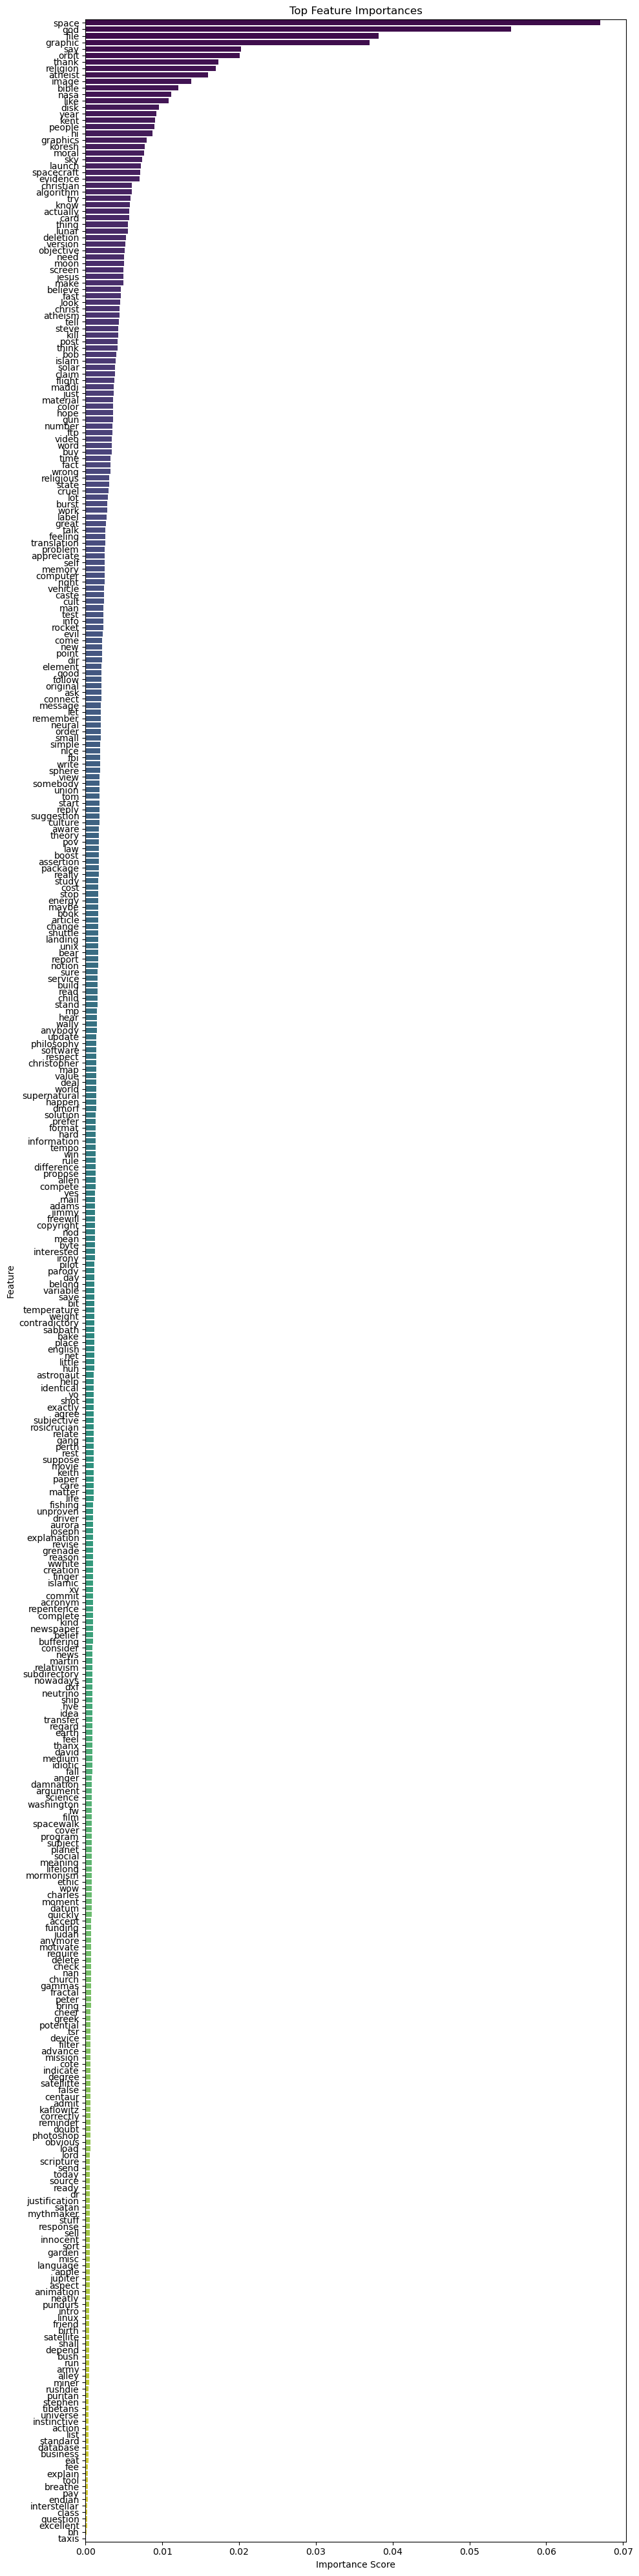

In [79]:
importances = tfidf_allTest.clf.feature_importances_
feature_importances_df = pd.DataFrame({
    'Feature': tfidf_allTest.get_X_train().columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

non_zero_importance = feature_importances_df[feature_importances_df['Importance'] > 0]
count_non_zero_importance = non_zero_importance.shape[0]
print("Anzahl der Zeilen mit Nicht-Null-Importanzwerten:", count_non_zero_importance)

top_features = non_zero_importance.head(count_non_zero_importance)

# Erstelle die Visualisierung
plt.figure(figsize=(10, 40))
sns.barplot(data=top_features, x="Importance", y="Feature", palette="viridis")
plt.title("Top Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Interpretation:
- erste Tests zeigen eine deutlich schlechtere Performance auf alle Kategorien im Vergleich zu 2 Kategorien (Dieser Vergleich basiert auf den Tests mit den anderen Ansätzen angewandt auf die 2 Kategorien, bin mir aber sogar unsicher)